In [ ]:
!pip install transformers datasets torch scikit-learn accelerate -q

import os
os.environ["WANDB_DISABLED"] = "true"   

import numpy as np
import pandas as pd
import torch
import re

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder

from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

from torch.nn import CrossEntropyLoss

df = pd.read_csv("tweets_ready_bert.csv", sep=",")   
df = df.dropna(subset=["tweets", "polarity"])
label_encoder = LabelEncoder()
df["polarity"] = label_encoder.fit_transform(df["polarity"])

num_labels = int(len(label_encoder.classes_))
id2label = {int(i): str(label) for i, label in enumerate(label_encoder.classes_)}
label2id = {str(label): int(i) for label, i in id2label.items()}

df = df.dropna(subset=["polarity"])

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["tweets"], df["polarity"], test_size=0.2, random_state=42, stratify=df["polarity"]
)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels
)
print("Class weights:", class_weights)

class_weights = torch.tensor(class_weights, dtype=torch.float)

tokenizer = BertTokenizerFast.from_pretrained("indobenchmark/indobert-base-p2")

def tokenize(batch):
    return tokenizer(
        batch["tweets"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
train_df = pd.DataFrame({
    "tweets": train_texts.astype(str),
    "labels": train_labels.astype(int)
})
test_df  = pd.DataFrame({
    "tweets": test_texts.astype(str),
    "labels": test_labels.astype(int)
})

train_dataset = Dataset.from_pandas(train_df)
test_dataset  = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p2",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

for name, param in model.bert.named_parameters():
    if "encoder.layer" in name and int(name.split(".")[2]) < 4:
        param.requires_grad = False

print("✅ IndoBERT model ready")

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )
    f1_macro = f1_score(
        labels, preds, average="macro"
    )

    return {
        "accuracy": acc,
        "precision_weighted": precision,
        "recall_weighted": recall,
        "f1_weighted": f1,
        "f1_macro": f1_macro
    }

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    save_steps=500,
    logging_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none"
)

trainer = WeightedTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

eval_results = trainer.evaluate()
print("\nEvaluation Results:")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"F1 Macro: {eval_results['eval_f1_macro']:.4f}\n")

preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[str(c) for c in label_encoder.classes_], digits=4))

Class weights: [1.03068933 1.3833967  0.76515948]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/2183 [00:00<?, ? examples/s]

Map:   0%|          | 0/546 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2019919765.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


✅ IndoBERT model ready


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,F1 Macro
1,0.879500,0.678687,0.723443,0.719154,0.723443,0.719922,0.703189
2,0.627300,0.638896,0.717949,0.720674,0.717949,0.719100,0.703006
3,0.400400,0.694766,0.725275,0.724902,0.725275,0.724132,0.706206
4,0.253900,0.818859,0.741758,0.738171,0.741758,0.739201,0.721414
5,0.154400,0.882435,0.728938,0.730529,0.728938,0.729655,0.713645


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument i


Evaluation Results:
Accuracy: 0.7418
F1 Macro: 0.7214



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Classification Report:
              precision    recall  f1-score   support

           0     0.6914    0.6364    0.6627       176
           1     0.6692    0.6591    0.6641       132
           2     0.8110    0.8655    0.8374       238

    accuracy                         0.7418       546
   macro avg     0.7239    0.7203    0.7214       546
weighted avg     0.7382    0.7418    0.7392       546



Sentiment Distribution:
Positive: 254 (46.52%)
Negative: 162 (29.67%)
Neutral: 130 (23.81%)


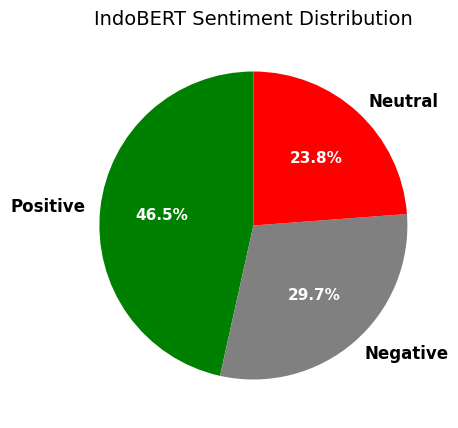

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

y_pred_classes = np.argmax(preds.predictions, axis=1)
label_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
y_labels = [label_map[i] for i in y_pred_classes]

cnt = Counter(y_labels)
total = len(y_labels)

print("Sentiment Distribution:")
for label, count in cnt.items():
    print(f"{label}: {count} ({count/total:.2%})")

df_dist = pd.DataFrame.from_dict(cnt, orient='index', columns=['Count'])
df_dist['Percentage'] = (df_dist['Count'] / total) * 100

plt.figure(figsize=(5, 5))

def white_autopct(pct):
    return f'{pct:.1f}%' if pct > 0 else ''

patches, texts, autotexts = plt.pie(
    df_dist['Count'],
    labels=df_dist.index,
    autopct=white_autopct,
    startangle=90,
    colors=['green', 'gray', 'red']  
)

for text in texts:
    text.set_color('black')
    text.set_fontsize(12)
    text.set_fontweight('bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

plt.title("IndoBERT Sentiment Distribution", fontsize=14, color='black')
plt.show()

cm_filename = "IndoBERT Sentiment Distribution.png"

from google.colab import files
files.download(cm_filename)


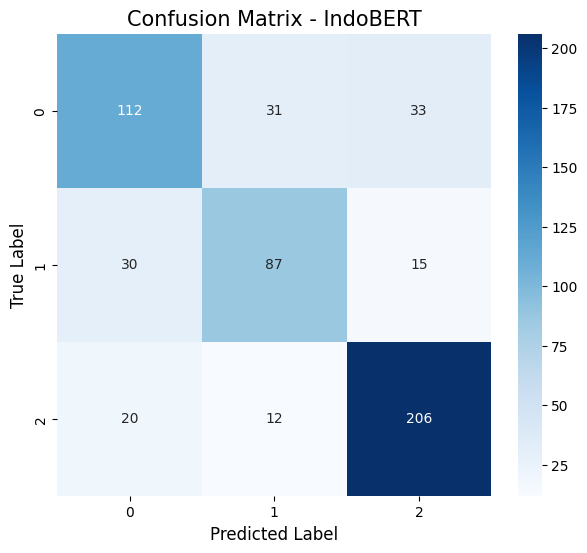

<Figure size 640x480 with 0 Axes>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert numeric labels → original text labels
labels = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix - IndoBERT", fontsize=15)
plt.show()

plt.tight_layout()
plt.savefig("IndoBERT Confusion Matrix.png", dpi=300)
plt.show()

cm_filename = "IndoBERT Confusion Matrix.png"

# DOWNLOAD in Colab
from google.colab import files
files.download(cm_filename)
